## **Sentiment Analysis**



Thanks to:

[Tensorflow base bert](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

[GIOVANI MACHADO](
https://www.kaggle.com/code/giovanimachado/hate-speech-bert-cnn-and-bert-mlp-in-tensorflow/notebook)


In [1]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd

In [3]:
# Regular imports
import numpy as np
import pandas as pd
import tqdm # for progress bar
import math
import random
import re

# Tensorflow Import
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_text as text
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## **Data Cleaning and Pre Processing**

In [4]:
def clean_text(tweet) :
        if not isinstance(tweet, str) :
            return 'DATA TO REMOVE'
        lower_cased = tweet.lower() # Put in lower case for easier processing
        removed_mentions_email = re.sub('[^ ]?@[^ ]*', '', lower_cased) # Remove mentions and e-mails
        
        url_pattern = re.compile(r'https?://\S+|www\.\S+') # find urls
        removed_urls = url_pattern.sub(r'', removed_mentions_email) # Removes urls
        
        removed_numbers = re.sub('[0-9]', '', removed_urls) # Remove numerical data
        removed_punc = re.sub('[^a-zA-Z ]*', '', removed_numbers) # Remove punctuations
        removed_trailing_spaces = re.sub(' +', ' ', removed_punc).strip() # Removes useless spaces 

        removed_rt = re.sub(' rt ', ' ', removed_trailing_spaces) # Remove 'RT' words in middle of texts
        splitted = removed_rt.split(' ', 1) # = [first word, rest of tweet]
        if splitted[0] == 'rt' : # We remove the rt at beggining of the text (first word)
            try : 
                cleaned_tweet = splitted[1]
            except IndexError : # This means the tweet is smthg like "rt USERNAME". It's useless we can remove it
                cleaned_tweet = 'DATA TO REMOVE'
        else :
            cleaned_tweet = removed_rt      
        return cleaned_tweet 

**Load Train dataset**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset using Twitter data, is used to research hate-speech detection. The text is classified as: hate-speech, offensive language, and neither. Due to the nature of the study, it’s important to note that this dataset contains text that can be considered racist, sexist, homophobic, or offensive.

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
# PATH = '/content/drive/MyDrive/Hate Speech/Datasets/'
PATH = '/content/drive/MyDrive/ML/SemProjec/'
df = pd.read_csv(PATH+'labeled_data.csv')


nRowsRead = None # specify 'None' if want to read whole file
# labeled_data.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
# df0 = pd.read_csv('/content/drive/MyDrive/Hate Speech/Datasets/labeled_data.csv', delimiter=',', nrows = nRowsRead)
df0 = pd.read_csv('/content/drive/MyDrive/ML/SemProjec/labeled_data.csv', delimiter=',', nrows = nRowsRead)
df0.dataframeName = 'labeled_data.csv'
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 24783 rows and 7 columns


In [7]:
df0.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


We transform the labels to numbers (These will be our individual classes). Numerical inputs are more compatible with machine learning frameworks in general.

In [8]:
#Doing some adjustments

c=df0['class']
df0.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1
24779,"you've gone and broke the wrong heart baby, an...",neither,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1
24781,youu got wild bitches tellin you lies,offensive_language,1


**Target Distribution**

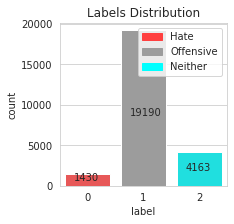

In [9]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
fig, ax= plt.subplots(figsize =(3,3))

ax = sns.countplot(x='label', data=df, palette=['#FF4040',"#9C9C9C","#00FFFF"]);
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.16, p.get_height()/2.2))

patch1 = mpatches.Patch(color='#FF4040', label='Hate')
patch2 = mpatches.Patch(color="#9C9C9C", label='Offensive')
patch3 = mpatches.Patch(color="#00FFFF", label='Neither')

plt.legend(handles=[patch1, patch2, patch3])
plt.title("Labels Distribution")
plt.show()

In [10]:
# Grouping data by label
df.groupby('label').count()

,text,category
label,,
0,1430,1430
1,19190,19190
2,4163,4163


In [11]:
df.to_csv('out.csv') 

In [12]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



**Removing garbage noise such as useless punctuation symbols, RT, mentions (@username)**

In [13]:
import re

def clean_tweet(tweet) :
    if not isinstance(tweet, str) :
        return 'DATA TO REMOVE'
    lower_cased = tweet.lower() # LOWER case
    removed_mentions_email = re.sub('[^ ]?@[^ ]*', '', lower_cased) # Remove mentions and e-mails
  
    url_pattern = re.compile(r'https?://\S+|www\.\S+') # find urls
    removed_urls = url_pattern.sub(r'', removed_mentions_email) # Removes urls
  
    removed_numbers = re.sub('[0-9]', '', removed_urls) # Remove numerical data
    removed_punc = re.sub('[^a-zA-Z ]*', '', removed_numbers) # Remove punctuations
    removed_trailing_spaces = re.sub(' +', ' ', removed_punc).strip() # Removes useless spaces 

    removed_rt = re.sub(' rt ', ' ', removed_trailing_spaces) # Remove 'RT' words in middle of texts
    splitted = removed_rt.split(' ', 1) # = [first word, rest of tweet]
    if splitted[0] == 'rt' : # We remove the rt at beggining of the text (first word)
        try :
            cleaned_tweet = splitted[1]
        except IndexError : # This means the tweet is smthg like "rt USERNAME". It's useless we can remove it
            cleaned_tweet = 'DATA TO REMOVE'
    else :
        cleaned_tweet = removed_rt
  
    return cleaned_tweet

df['text'] = df['text'].apply(lambda x: clean_tweet(x))
df = df[df['text'] != 'DATA TO REMOVE']
# test_df['text'] = test_df['text'].apply(lambda x: clean_tweet(x))
# test_df = test_df[test_df['text'] != 'DATA TO REMOVE']
df.head(10)

,text,category,label
0,as a woman you shouldnt complain about cleanin...,neither,2
1,boy dats coldtyga dwn bad for cuffin dat hoe i...,offensive_language,1
2,dawg you ever fuck a bitch and she start to cr...,offensive_language,1
3,she look like a tranny,offensive_language,1
4,the shit you hear about me might be true or it...,offensive_language,1
5,the shit just blows meclaim you so faithful an...,offensive_language,1
6,i can not just sit up and hate on another bitc...,offensive_language,1
7,cause im tired of you big bitches coming for u...,offensive_language,1
8,amp you might not get ya bitch back amp thats ...,offensive_language,1
9,hobbies include fighting mariambitch,offensive_language,1


**Removing Stopwords**

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
# print(stop)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# test_df['text'] = test_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,category,label
0,woman shouldnt complain cleaning house amp man...,neither,2
1,boy dats coldtyga dwn bad cuffin dat hoe st place,offensive_language,1
2,dawg ever fuck bitch start cry confused shit,offensive_language,1
3,look like tranny,offensive_language,1
4,shit hear might true might faker bitch told ya,offensive_language,1
5,shit blows meclaim faithful somebody still fuc...,offensive_language,1
6,sit hate another bitch got much shit going,offensive_language,1
7,cause im tired big bitches coming us skinny girls,offensive_language,1
8,amp might get ya bitch back amp thats,offensive_language,1
9,hobbies include fighting mariambitch,offensive_language,1


**Tokenization**

Tokenization is a method of breaking down a piece of text (the tweet) into smaller pieces (words). It converts a string of text into a list of strings, each string representing one of the tweet's words.

In [15]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['text'] = df['text'].apply(lambda x: tokenization(x.lower()))
df.head(10)

,text,category,label
0,"[woman, shouldnt, complain, cleaning, house, a...",neither,2
1,"[boy, dats, coldtyga, dwn, bad, cuffin, dat, h...",offensive_language,1
2,"[dawg, ever, fuck, bitch, start, cry, confused...",offensive_language,1
3,"[look, like, tranny]",offensive_language,1
4,"[shit, hear, might, true, might, faker, bitch,...",offensive_language,1
5,"[shit, blows, meclaim, faithful, somebody, sti...",offensive_language,1
6,"[sit, hate, another, bitch, got, much, shit, g...",offensive_language,1
7,"[cause, im, tired, big, bitches, coming, us, s...",offensive_language,1
8,"[amp, might, get, ya, bitch, back, amp, thats]",offensive_language,1
9,"[hobbies, include, fighting, mariambitch]",offensive_language,1


**Replacement of Chat words**

In [16]:
replaced_words = [("hmmyou",""),("sry","sorry"),("inlove","in love"),("thats",""),("wanna",""),
                  ("soo","so"),("inlove","in love"),("amazingwell","amazing well"),
                  ("messagesorry","message sorry"),("½",""),("tomorrowneed","tomorrow need"),
                  ("tomorrowis","tomorrow is"),("amusedtime","amused time"),("weekendor","weekend or"),
                  ("competitionhope","competition hope"),("partypicnic","party picnic"),
                  ("ahmazing","amazing"),("wont","will not"),("didnt","did not"),("dont","do not"),
                  ("lookin","looking"),("u","you"),("youre","you are"),("nite","night"),("isnt","is not"),
                  ("k",""),("is",""),("doesnt","does not"),("l",""),("x",""),("c",""),("ur","your"),
                  ("e",""),("yall","you all"),("he",""),("us",""),("okim","ok i am"),("jealousi","jealous"),
                  ("srry","sorry"),("itll","it will"),("vs",""),("weeknend","weekend"),("w",""),
                  ("yr","year"),("youve","you have"),("havent","have not"),("iï",""),("gonna","going to"),
                  ("gimme","give me"),("ti",""),("ta",""),("thru","through"),("th",""),("imma","i am going to"),
                  ("wasnt","was not"),("arent","are not"), ("bff","best friend forever"),("sometimesdid","sometimes did"),
                  ("waitt","wait"),("bday","birthday"),("toobut","too but"),("showerand","shower and"),
                  ("innit","is not it"),("surgury","surgery"),("soproudofyo","so proud of you"),("p",""),
                  ("couldnt","could not"),("dohforgot","forgot"),("rih","right"),("b",""),("bmovie","movie"),
                  ("pleaseyour","please your"),("tonite","tonight"),("grea","great"),("se",""),("soonso","soon so"),
                  ("gettin","getting"),("blowin","blowing"),("coz","because"),("thanks","thank"),("st",""),("rd",""),
                  ("gtta","have got to"),("gotta","have got to"),("anythingwondering","anything wondering"),
                  ("annoyedy","annoyed"),("p",""),("beatiful","beautiful"),("multitaskin","multitasking"),
                  ("nightmornin","night morning"),("thankyou","thank you"),("iloveyoutwoooo","i love you two"),
                  ("tmwr","tomorrow"),("wordslooks","words looks"),("ima","i am going to"),("liek","like"),("mr",""),
                  ("allnighter","all nighter"),("tho","though"),("ed",""),("fyou",""),("footlong","foot long"),
                  ("placepiggy","place piggy"),("semiflaky","semi flaky"),("gona","going to"),("tmr","tomorrow"),
                  ("ppl","people"),("n",""),("dis","this"),("dun","done"),("houseee","house"),("havee","have"),
                  ("studyingwhew","studying whew"),("awwyoure","aww you are"),("softyi","softy"),
                  ("weddingyou","wedding you"),("hassnt","has not"),("lowerleft","lower left"),("anywayss","anyway"),
                  ("adoarble","adorable"),("blogyeahhhh","blog yeahhhh"),("billsim","bills i am"),("ps",""),
                  ("cheescake","cheesecake"),("morningafternoonnight","morning after noon night"),
                  ("allstudying","all studying"),("ofcoooursee","of course"),("jst","just"),("shes","she is"),
                  ("sonicswhich","sonics which"),("ouchwaited","ouch waited"),("itll","it will"),("orreply","or reply"),
                  ("somethin","something"),("fridayand","friday and"),("outta","out of"),("herenever","here never")
                 ] 

def replace_words(text,replaced_words):
    ind = -1 
    for word in text:
        ind +=1
        for k in range(len(replaced_words)):
            if word == replaced_words[k][0]:
                text[ind] = replaced_words[k][1]
            elif "http" in word:
                text[ind] = ""
            elif "@" in word:
                text[ind] = ""
            elif "www." in word:
                text[ind] = ""
            elif "Â" in word: 
                text[ind] = ""
            elif "Ã" in word: 
                text[ind] = ""
            elif "½" in word:
                text[ind] = ""
    return text

df['text'] = df['text'].apply(lambda x: replace_words(x,replaced_words))
df.head(10)

,text,category,label
0,"[woman, shouldnt, complain, cleaning, house, a...",neither,2
1,"[boy, dats, coldtyga, dwn, bad, cuffin, dat, h...",offensive_language,1
2,"[dawg, ever, fuck, bitch, start, cry, confused...",offensive_language,1
3,"[look, like, tranny]",offensive_language,1
4,"[shit, hear, might, true, might, faker, bitch,...",offensive_language,1
5,"[shit, blows, meclaim, faithful, somebody, sti...",offensive_language,1
6,"[sit, hate, another, bitch, got, much, shit, g...",offensive_language,1
7,"[cause, im, tired, big, bitches, coming, , ski...",offensive_language,1
8,"[amp, might, get, ya, bitch, back, amp, ]",offensive_language,1
9,"[hobbies, include, fighting, mariambitch]",offensive_language,1


**Lemmatization**

Lemmatization removes the grammar tense and restores the original form of each word. Lemmatization is the process of converting a word into its lemma form. For example, if we lemmatize the word "books", we get the term "book".

In [17]:
nltk.download('wordnet')
nltk.download('omw-1.4')
l = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [l.lemmatize(word) for word in text]
    return text

df['text'] = df["text"].apply(lambda x: lemmatizer(x))
df.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,text,category,label
0,"[woman, shouldnt, complain, cleaning, house, a...",neither,2
1,"[boy, dat, coldtyga, dwn, bad, cuffin, dat, ho...",offensive_language,1
2,"[dawg, ever, fuck, bitch, start, cry, confused...",offensive_language,1
3,"[look, like, tranny]",offensive_language,1
4,"[shit, hear, might, true, might, faker, bitch,...",offensive_language,1
5,"[shit, blow, meclaim, faithful, somebody, stil...",offensive_language,1
6,"[sit, hate, another, bitch, got, much, shit, g...",offensive_language,1
7,"[cause, im, tired, big, bitch, coming, , skinn...",offensive_language,1
8,"[amp, might, get, ya, bitch, back, amp, ]",offensive_language,1
9,"[hobby, include, fighting, mariambitch]",offensive_language,1


**Converitng back the tokens to string**

In [18]:
df['text'] = df['text'].apply(lambda x: ' '.join(str(e) for e in x))
df.head(10)

,text,category,label
0,woman shouldnt complain cleaning house amp man...,neither,2
1,boy dat coldtyga dwn bad cuffin dat hoe place,offensive_language,1
2,dawg ever fuck bitch start cry confused shit,offensive_language,1
3,look like tranny,offensive_language,1
4,shit hear might true might faker bitch told ya,offensive_language,1
5,shit blow meclaim faithful somebody still fuck...,offensive_language,1
6,sit hate another bitch got much shit going,offensive_language,1
7,cause im tired big bitch coming skinny girl,offensive_language,1
8,amp might get ya bitch back amp,offensive_language,1
9,hobby include fighting mariambitch,offensive_language,1


## Data Visualization

**WordCloud**

<class 'set'>


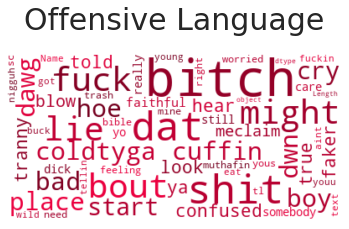

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(df.loc[df["category"]=="offensive_language"].text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Offensive Language', fontsize=30, pad=25)
plt.show()

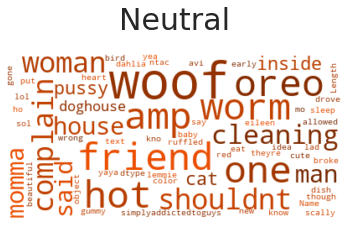

In [20]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="neither"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Neutral', fontsize=30, pad=25)

plt.show()

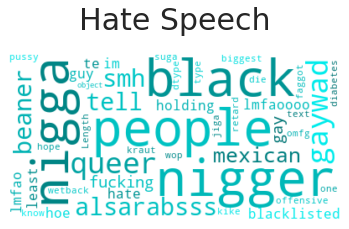

In [21]:
stopwords.add("Name")

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 180
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="hate_speech"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Hate Speech', fontsize=30, pad=25)

plt.show()

**Bigrams**

In [22]:
from sklearn.feature_extraction.text import CountVectorizer


In [23]:
def bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

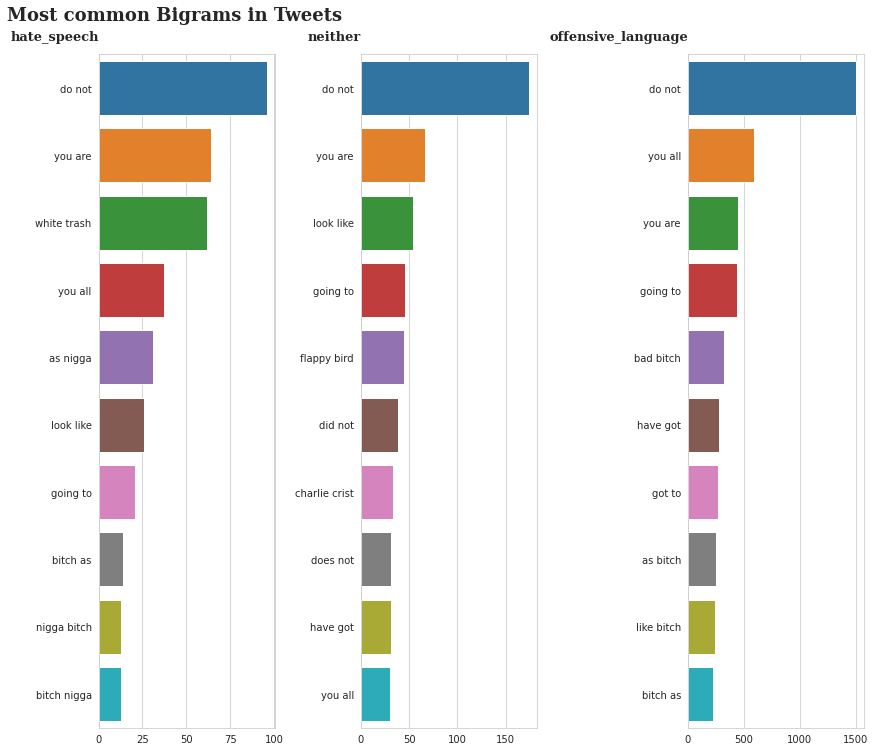

In [24]:
fig, axes = plt.subplots(1,3, figsize=(12, 10), constrained_layout=True)

sentiment_list = list(np.unique(df['category']))

for i, sentiment in zip(range(3), sentiment_list):
    top_tweet_bigrams = bigrams(df[df['category']==sentiment]['text'].fillna(" "))[:10]
    x,y = map(list,zip(*top_tweet_bigrams))
    sns.barplot(x=y, y=x, ax=axes[i])
    axes[i].text(0,-0.7, sentiment, fontweight="bold", fontfamily='serif', fontsize=13,ha="right")
    axes[i].patch.set_alpha(0)

fig.text(0,1.01,"Most common Bigrams in Tweets", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

## Model

**Splitting**

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

In [28]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [29]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test         143
                         train       1158
                         val          129
neither            2     test         416
                         train       3372
                         val          375
offensive_language 1     test        1920
                         train      15543
                         val         1727

In [30]:
df

,text,category,label,data_type
0,woman shouldnt complain cleaning house amp man...,neither,2,test
1,boy dat coldtyga dwn bad cuffin dat hoe place,offensive_language,1,train
2,dawg ever fuck bitch start cry confused shit,offensive_language,1,train
3,look like tranny,offensive_language,1,train
4,shit hear might true might faker bitch told ya,offensive_language,1,train
...,...,...,...,...
24778,yous muthafin lie right tl trash mine bible sc...,offensive_language,1,train
24779,you have gone broke wrong heart baby drove red...,neither,2,train
24780,young buck eat dat nigguh like aint fuckin this,offensive_language,1,train
24781,youu got wild bitch tellin lie,offensive_language,1,train


In [31]:
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

,text,category,label,data_type
1,boy dat coldtyga dwn bad cuffin dat hoe place,offensive_language,1,train
2,dawg ever fuck bitch start cry confused shit,offensive_language,1,train
3,look like tranny,offensive_language,1,train
4,shit hear might true might faker bitch told ya,offensive_language,1,train
6,sit hate another bitch got much shit going,offensive_language,1,train


In [32]:
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,text,category,label,data_type
5,shit blow meclaim faithful somebody still fuck...,offensive_language,1,val
27,met pussy ocean dr gave pussy pill,offensive_language,1,val
31,id say im back old old bitch would get excited,offensive_language,1,val
44,post picture pussy get like,offensive_language,1,val
46,quick piece pussy call drive,offensive_language,1,val


In [33]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,text,category,label,data_type
0,woman shouldnt complain cleaning house amp man...,neither,2,test
12,hoe smoke loser yea go ig,offensive_language,1,test
14,bitch get,offensive_language,1,test
17,bitch love,offensive_language,1,test
25,pussy lip like heaven door,offensive_language,1,test


In [34]:
df.dtypes

text         object
category     object
label         int64
data_type    object
dtype: object

In [35]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

In [36]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [37]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [38]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

 **BERT**

We experimented with many pre-trained models of BERT (cased and uncased). The uncased model worked better than the cased models



In [39]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [40]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [41]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Tweet: b'tf chrisis jones nigga botta get as beat clearly bitch nigga you see real nigga conversatin'
Label : 1
Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1056  2546  3782  2483  3557  9152 23033 28516  2696  2131  2004]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [42]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [43]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9701985   0.9932277   0.14925227  0.15058059  0.39221513  0.82833284
  0.9814284  -0.9966501  -0.29812905 -0.9951346   0.30043295 -0.63356316]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.155288   -0.01815351  0.642665   ... -0.8672859   0.60164654
  -0.85784   ]
 [-0.60137135  0.8930322   0.7279932  ... -1.1858964   0.10059667
  -0.20934643]
 [-0.3122725  -0.20154577  0.553474   ... -1.0642492   1.0998992
   0.11761759]
 ...
 [-0.125364   -1.0116832  -0.5065198  ... -0.27892047  0.62747425
   0.191234  ]
 [-0.6180317   0.12795377  0.15281361 ... -0.28832096 -0.117222
   0.21216734]
 [ 0.4542821   0.186066   -0.12121868 ... -0.7678787  -0.34991935
  -0.6893995 ]]


In [44]:
weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / ofensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


In [45]:
#initial_output_bias = np.array([3.938462, 6.535164, 5.])
initial_output_bias = np.array([3.938462, 15, 5.])
initial_output_bias 

array([ 3.938462, 15.      ,  5.      ])

In [46]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        #print(output_bias)
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)

In [47]:
classifier_model = build_classifier_model(output_bias=initial_output_bias)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.50000584 0.73104966 0.5000055 ]], shape=(1, 3), dtype=float32)


In [48]:
classifier_model.get_weights()[-1]

array([ 3.938462, 15.      ,  5.      ], dtype=float32)

In [49]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

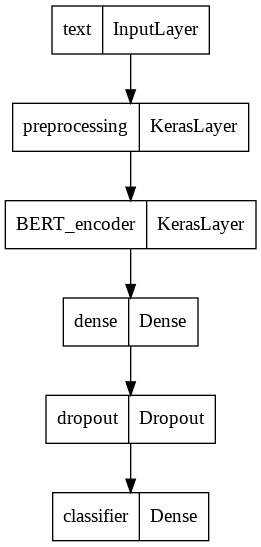

In [50]:
tf.keras.utils.plot_model(classifier_model)

## **Training**

In [51]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [52]:
!pip install -q tf-models-official==2.7.0
from official.nlp import optimization  # to create AdamW optimizer

In [53]:
epochs = 100
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [54]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [55]:
es = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max'
)

best_model_path = "/content/drive/MyDrive/ML/SemProjec/model.{epoch:02d}-{val_loss:.2f}.h5"
cp =  ModelCheckpoint(best_model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1)


In [56]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[es, 
                                          #  cp
                                          ], 
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


628/628 [==============================] - 125s 183ms/step - loss: 4.1946 - accuracy: 0.7292 - val_loss: 0.9832 - val_accuracy: 0.5424
Epoch 2/100
628/628 [==============================] - 111s 176ms/step - loss: 0.8947 - accuracy: 0.7171 - val_loss: 0.5675 - val_accuracy: 0.7970
Epoch 3/100
628/628 [==============================] - 111s 176ms/step - loss: 0.6699 - accuracy: 0.7961 - val_loss: 0.5181 - val_accuracy: 0.7660
Epoch 4/100
628/628 [==============================] - 111s 176ms/step - loss: 0.5634 - accuracy: 0.8255 - val_loss: 0.4700 - val_accuracy: 0.8091
Epoch 5/100
628/628 [==============================] - 110s 175ms/step - loss: 0.5003 - accuracy: 0.8391 - val_loss: 0.4097 - val_accuracy: 0.8687
Epoch 6/100
628/628 [==============================] - 109s 174ms/step - loss: 0.4653 - accuracy: 0.8598 - val_loss: 0.3945 - val_accuracy: 0.8391
Epoch 7/100
628/628 [==============================] - 109s 174ms/step - loss: 0.4309 - accuracy: 0.8708 - val_loss: 0.3612 - val_

**Evaluating the model on training and validation datasets**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


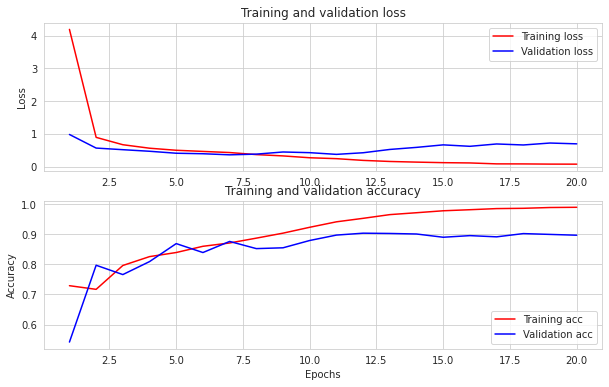

In [57]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## **Test**

Calculating loss and accuracy on the test dataset

In [58]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 8s 107ms/step - loss: 0.6740 - accuracy: 0.8955
Loss: 0.6739981770515442
Accuracy: 0.89552241563797


# **Save model**

Saving the model to so that it can be easily used when we input a video

In [59]:
dataset_name = 'hs'
saved_model_path = '/content/drive/MyDrive/ML/SemProjec/{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/SemProjec/hs_bert/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/SemProjec/hs_bert/assets


**Doing predictions and saving to np.array**

In [60]:
tweets = []
tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  tweets.append(tweet)
  test_labels.append(labels.numpy())
  predictions.append(classifier_model.predict(tweet))

1/1 [==============================] - 1s 692ms/step


In [61]:
from itertools import chain
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)

In [62]:
y_test = np.array(list(chain.from_iterable(test_labels)))

In [63]:
tweets = np.array(list(chain.from_iterable(tweets)))

In [64]:
print(len(tweets))

2479


**Confusion Matrix**

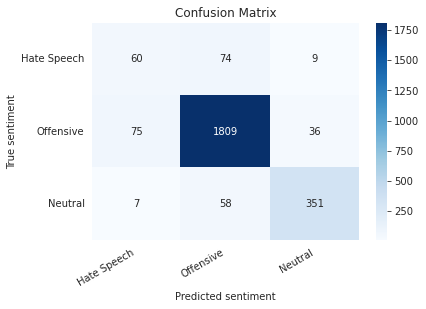

In [65]:
from sklearn.metrics import confusion_matrix

class_names = ['Hate Speech', 'Offensive', 'Neutral']

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  plt.title('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

**Some tweets in which the model fails**

In [66]:
dfObj = pd.DataFrame(columns=['text', 'True_Label', 'Predict_Label'])

for i in range(len(tweets)):

    if (y_test[i]!=y_pred[i]):
      label_t = class_names[y_test[i]]
      label_p = class_names[y_pred[i]]

      dfObj = dfObj.append({'text': tweets[i], 'True_Label': label_t, 'Predict_Label': label_p}, ignore_index=True)

dfObj.to_csv('missclassification.csv', index=False)

In [68]:
dfObj.sort_values(['True_Label','Predict_Label'],ascending=True).groupby('True_Label').head(3)

,text,True_Label,Predict_Label
54,b'typical coon activity',Hate Speech,Neutral
66,b'stupid redneck animal husbandry mean get hit...,Hate Speech,Neutral
67,b'jennifer lawrence nude sooooo trash im still...,Hate Speech,Neutral
4,b'use call mom jap younger lol asian racial slur',Neutral,Hate Speech
17,b'favorite episode friend one black mysterious...,Neutral,Hate Speech
53,b'welfaregovernment aid claimed white people y...,Neutral,Hate Speech
0,b'nice avi lil nigger',Offensive,Hate Speech
2,b'jerryspringer raw white trash side applauding',Offensive,Hate Speech
5,b'remember said uchihas faggot week sasuke rea...,Offensive,Hate Speech
